In [1]:
from torch_geometric.datasets import Planetoid, MNISTSuperpixels
from torchvision.datasets import MNIST
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
from torch_geometric.data import NeighborSampler
import wandb
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
import numpy as np
from utils import get_graph_from_image 
from torch_geometric.data import Data

In [2]:
print("Reading dataset")
dataset = MNIST("data/mnist", download=True)

Reading dataset


60000
(60000, 28, 28, 1)


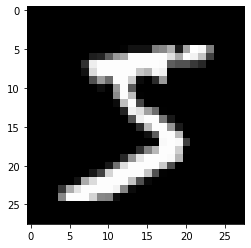

In [3]:
imgs = dataset.data.unsqueeze(-1).numpy().astype(np.float64)
print(len(imgs))
print(imgs.shape)


first_image = imgs[0]
plt.imshow(first_image, cmap='gray')
plt.show()

In [4]:
# dataset = Planetoid(root = '../data/cora', name='Cora')
# dataset = MNISTSuperpixels(root = '../data/mnist')

labels = dataset.targets.numpy()

x, edge_index = get_graph_from_image(first_image)

x = torch.tensor(x, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long)

print(edge_index.shape)
print(x.shape)

data = Data(x=x, edge_index=edge_index)
print(data.num_nodes)
print(data)


G = to_networkx(data, node_attrs=['x'])
nx.draw(G, cmap=plt.get_cmap('Set1'), node_size=75, linewidths=6)
plt.show()


SLIC number of segments: 77


ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (629,1)

In [5]:
# print("Processing images into graphs...", end="")
# ptime = time.time()
# with multiprocessing.Pool() as p:
#     graphs = np.array(p.map(util.get_graph_from_image, imgs))
# del imgs
# ptime = time.time() - ptime
# print(" Took {ptime}s".format(ptime=ptime))



In [6]:
# print(len(dataset))
# print(dataset.num_classes)
# print(dataset.num_node_features)
# print(dataset.num_edge_features)
# print(dataset[0])
# print(dataset[0].is_directed())
# print(dataset[0]['x'])
# print(dataset[0]['train_mask'])